<a href="https://colab.research.google.com/github/suleman12344/Final_YearProject/blob/main/Model/finalYear2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
import torchvision.transforms as transforms

In [34]:
# Custom Dataset
import matplotlib.pyplot as plt

class FloorPlanDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        #print(pd.read_csv(csv_file))
        self.img_dir = img_dir
        #print(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 4])# Image path column
        #print(img_path)
        image = Image.open(img_path).convert('RGB')
        #plt.imshow(image)
        #plt.show()
        if self.transform:
            image = self.transform(image)

        # Normalize numerical features
        features = torch.tensor([
            self.data.iloc[idx, 0] / 4000.0,  # Square Feet
            self.data.iloc[idx, 1] / 4.0,     # Beds
            self.data.iloc[idx, 2] / 4.0,     # Baths
            self.data.iloc[idx, 3] / 3.0      # Garages
        ], dtype=torch.float)

        return features, image

In [45]:
class Generator(nn.Module):
    def __init__(self, latent_dim, feature_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.input_layer = nn.Sequential(
            nn.Linear(latent_dim + feature_dim, 512 * 4 * 4),
            nn.ReLU()
        )

        self.main = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, features):
        x = torch.cat([z, features], 1)
        x = self.input_layer(x)
        x = x.view(-1, 512, 4, 4)
        return self.main(x)

In [46]:
class Discriminator(nn.Module):
    def __init__(self, feature_dim):
        super(Discriminator, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )

        self.feature_layer = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(0.2)
        )

        self.output_layer = nn.Sequential(
            nn.Linear(512 * 8 * 8 + 512, 1),
            nn.Sigmoid()
        )

    def forward(self, x, features):
        batch_size = x.size(0)
        x = self.conv(x)
        x = x.view(batch_size, -1)
        f = self.feature_layer(features)
        x = torch.cat([x, f], dim=1)
        return self.output_layer(x)

In [49]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_model(generator, discriminator, dataloader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    latent_dim = 100
    feature_dim = 4

    generator = generator.to(device)
    discriminator = discriminator.to(device)

    # Reduced learning rates
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    criterion = nn.BCELoss()

    # Add noise to labels for smoother training
    def noisy_labels(size, prob=0.05):
        labels = torch.ones(size)
        labels = labels - prob * torch.rand(size)
        return labels

    for epoch in range(num_epochs):
        for i, (features, real_images) in enumerate(dataloader):
            batch_size = features.size(0)

            # Noisy labels instead of pure ones and zeros
            real_labels = noisy_labels((batch_size, 1)).to(device)
            fake_labels = noisy_labels((batch_size, 1), prob=0.3).to(device)

            # Train Discriminator
            for _ in range(1):  # Reduced discriminator training frequency
                d_optimizer.zero_grad()
                real_images = real_images.to(device)
                features = features.to(device)

                d_output_real = discriminator(real_images, features)
                d_loss_real = criterion(d_output_real, real_labels)

                z = torch.randn(batch_size, latent_dim).to(device)
                fake_images = generator(z, features)
                d_output_fake = discriminator(fake_images.detach(), features)
                d_loss_fake = criterion(d_output_fake, fake_labels)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            g_output = discriminator(fake_images, features)
            g_loss = criterion(g_output, real_labels)
            g_loss.backward()
            g_optimizer.step()

            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], '
                      f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

                # Save generated image
                z = torch.randn(1, latent_dim).to(device)
                sample_features = features[0].unsqueeze(0)
                with torch.no_grad():
                    generated_image = generator(z, sample_features).cpu()
                plt.figure(figsize=(6,6))
                plt.imshow(generated_image[0].permute(1, 2, 0) * 0.5 + 0.5)
                plt.axis('off')
                plt.show()
                plt.close()

Dataset length: 20
Dataloader length: 1
Epoch [0/10], Step [0/1], d_loss: 1.3482, g_loss: 0.6472


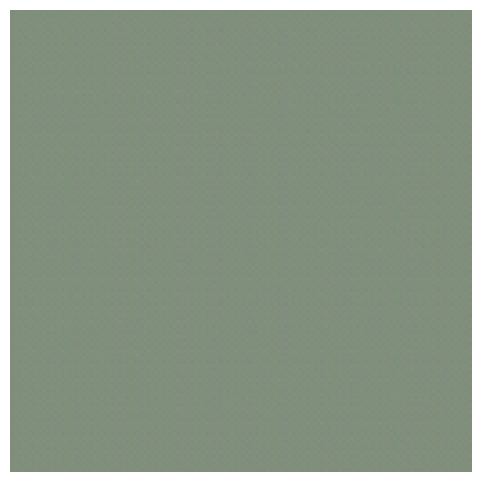

Epoch [1/10], Step [0/1], d_loss: 1.2283, g_loss: 0.6163


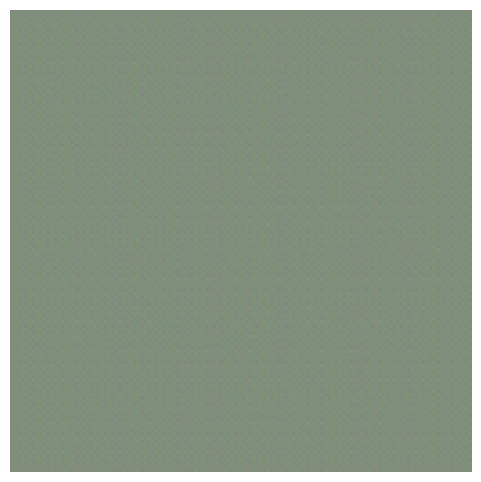

Epoch [2/10], Step [0/1], d_loss: 1.0776, g_loss: 0.5686


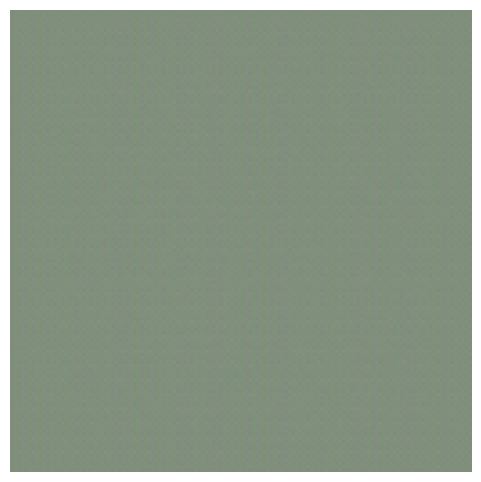

Epoch [3/10], Step [0/1], d_loss: 0.8842, g_loss: 0.4923


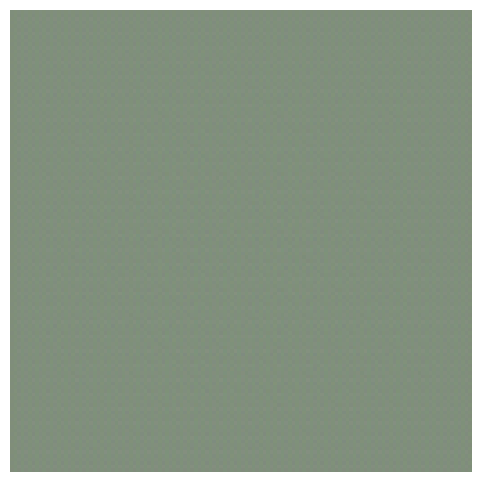

Epoch [4/10], Step [0/1], d_loss: 0.6919, g_loss: 0.3903


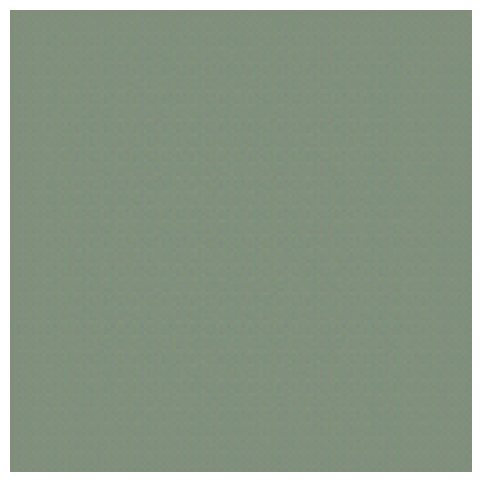

Epoch [5/10], Step [0/1], d_loss: 0.6113, g_loss: 0.3017


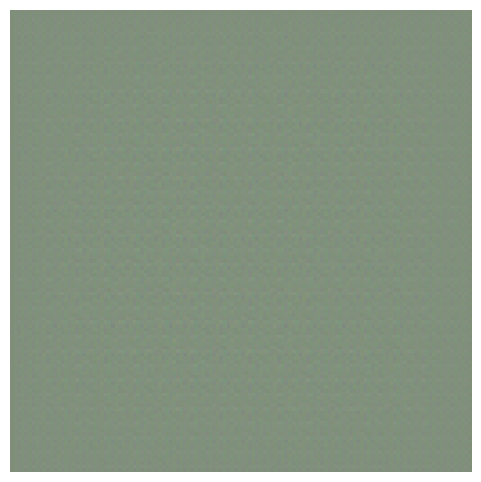

Epoch [6/10], Step [0/1], d_loss: 0.5466, g_loss: 0.2322


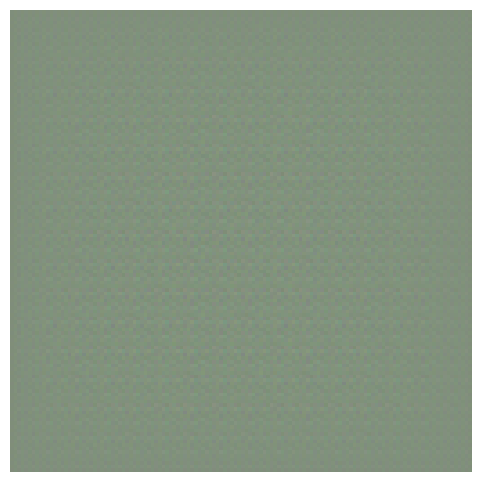

Epoch [7/10], Step [0/1], d_loss: 0.6034, g_loss: 0.2199


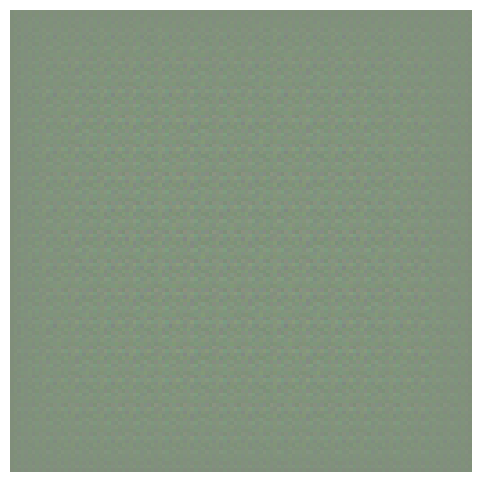

Epoch [8/10], Step [0/1], d_loss: 0.5574, g_loss: 0.2239


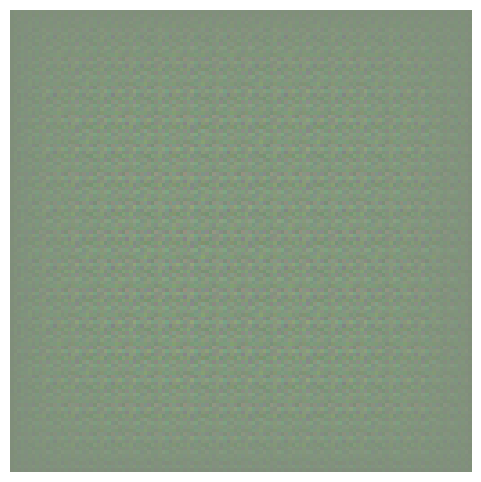

Epoch [9/10], Step [0/1], d_loss: 0.5948, g_loss: 0.2560


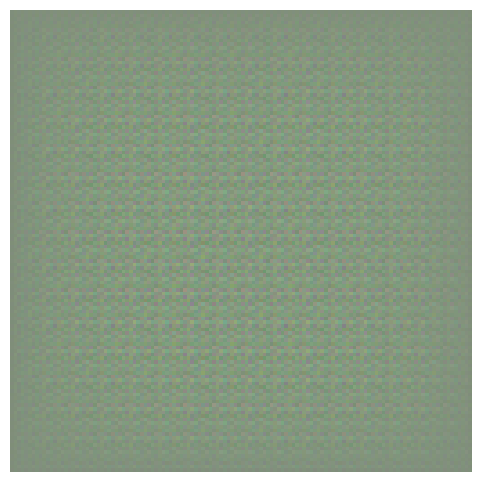

In [50]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def main():

    # Hyperparameters
    batch_size = 32
    latent_dim = 100
    feature_dim = 4
    image_size = 128

    # Data preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create dataset and dataloader
    dataset = FloorPlanDataset(
        csv_file='/content/drive/MyDrive/smaller dataset/house_plans_details.csv',
        img_dir='/content/drive/MyDrive/smaller dataset/',

        transform=transform
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print("Dataset length:", len(dataset))
    print("Dataloader length:", len(dataloader))
    # Initialize networks
    generator = Generator(latent_dim, feature_dim)
    discriminator = Discriminator(feature_dim)

    # Train the model
    train_model(generator, discriminator, dataloader)

if __name__ == "__main__":

    main()
